In [1]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
from scipy.constants import pi, c
from scipy.signal import hilbert, find_peaks
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [2]:
plt.rcParams['figure.figsize'] = [10,5]

In [3]:
#Define conversion functions/factors to get to/from meep units and kms
#Length factor to transform lengths in kms
l_unit = 1e-6 #1 um
t_unit = l_unit/c #time unit is length/c

#multiplicative constants to convert frequencies from meep to kms hertz
freq_unit = c/l_unit

print("1 meep Length unit is", l_unit*1e+6, "um")
print("1 meep Time unit is", t_unit*1e+15, "fs")
print("1 meep Frequency unit is", freq_unit*1e-12, "THz")

1 meep Length unit is 1.0 um
1 meep Time unit is 3.3356409519815204 fs
1 meep Frequency unit is 299.792458 THz


# Resolution

In [4]:
#courant factor
S = 0.5

#resolution is number of pixels per meep unit
resolution = 20

#resolutions in meep units
space_res = 1/resolution
time_res = space_res*S

print("Pixel per unit: ", resolution)

print("Space resolution [meep]: ", space_res)
print("Time resolution [meep]: ", time_res)

print("Space resolution [um]: ", space_res*l_unit*1e+6)
print("Time resolution [fs]: ", time_res*t_unit*1e+15)

time_freq = 1/time_res
print("Time sampling frequency [meep]: ", time_freq)
print("Nyqvist frequency [meep]: ", time_freq/2)

Pixel per unit:  20
Space resolution [meep]:  0.05
Time resolution [meep]:  0.025
Space resolution [um]:  0.049999999999999996
Time resolution [fs]:  0.08339102379953803
Time sampling frequency [meep]:  40.0
Nyqvist frequency [meep]:  20.0


# Geometry Definition
Cell

In [5]:
#define cell size and resolution
#Cell size is in meep units
#center is in (0,0), ranges in x=(-sx/2,sx/2), y=(-sy/2,sy/2)
sx = 32
sy = 20

cell = mp.Vector3(sx, sy)

#boundary conditions thickness
pml_thickness = 1.0

#automatic positioning of boundaries
x_bound_up = sx/2 - pml_thickness
x_bound_low = -sx/2 + pml_thickness

y_bound_up = sy/2 - pml_thickness
y_bound_low = -sy/2 + pml_thickness

In [6]:
#materials refractive indexes
n_bgnd = 1
n_wvg = 3.55

#Width properties
wvg_width = 1.6

#Position properties
wvg_x = 0
wvg_y = 0

Source

In [7]:
#Soure parameters
source_x = x_bound_low + 1
source_y = wvg_y

source_width = wvg_width

#note: df is not really the frequency sigma
f_central = 0.9
df = f_central/2

f_harm = f_central
df_harm = df

print("#Source pulse frequency: fcent= ", f_central, " m.u., df= ",df, " m.u." )
print("#Source pulse frequency: fcent= ", f_central*freq_unit*1e-12, " THz, df= ",df*freq_unit*1e-12, " THz" )
print("#Source vacuum wavelength: lambda = ",  c/(f_central*freq_unit)*1e+6, "um, dlambda = ",c/(df*freq_unit)*1e+6,"um")
print("#Source wvg wavelength: lambda = ",  (c/n_wvg)/(f_central*freq_unit)*1e+6, "um")

#Source pulse frequency: fcent=  0.9  m.u., df=  0.45  m.u.
#Source pulse frequency: fcent=  269.8132122  THz, df=  134.9066061  THz
#Source vacuum wavelength: lambda =  1.111111111111111 um, dlambda =  2.222222222222222 um
#Source wvg wavelength: lambda =  0.3129890453834116 um


Monitors

In [8]:

#Monitor parameters
#input
mon_1_x = source_x + 0.5
mon_1_y = wvg_y
mon_1_width = wvg_width

#output
mon_2_x = x_bound_up - 1
mon_2_y = wvg_y
mon_2_width = wvg_width

#number of sampling points in frequency for fourier transform of fields accumulated
N_freq = 300

#central frequency
f_mon_central = f_central
#width of sampled frequency band
df_mon = df


#Point for simulation termination condition
check_pt = mp.Vector3(mon_2_x - 0.1, mon_2_y)

# Broad run

-----------
Initializing structure...
time for choose_chunkdivision = 0.000451088 s
Working in 2D dimensions.
Computational cell is 32 x 20 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.6,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.6025,12.6025,12.6025)
time for set_epsilon = 0.350501 s
-----------
on time step 1318 (time=32.95), 0.00303542 s/step
on time step 2859 (time=71.475), 0.00259672 s/step
field decay(t = 100.025): 1.45538086979167e-10 / 1.45538086979167e-10 = 1.0
on time step 4516 (time=112.9), 0.00241499 s/step
on time step 6070 (time=151.75), 0.0025744 s/step
on time step 7758 (time=193.95), 0.0023705 s/step
field decay(t = 200.05): 0.006631865361897191 / 0.006631865361897191 = 1.0
on time step 9344 (time=233.6), 0.00252287 s/step
on time step 11009 (time=275.225), 0.00240242 s/step
field decay(t = 300.075): 5.7962372259050745e-06 / 0.006631865361897191 = 0.0008739980246292174
Normalizing 

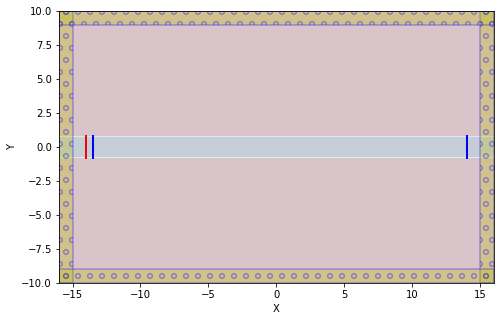

In [9]:
#Geometry objects
waveguide = mp.Block(mp.Vector3(mp.inf, wvg_width, mp.inf),
                    center = mp.Vector3(wvg_x, wvg_y),
                    material = mp.Medium(index=n_wvg))

geometry = [waveguide]

#define sources
#gaussian pulse with f_central and df
sources = [mp.Source(mp.GaussianSource(frequency=f_central, fwidth=df*3),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, source_width))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]

#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    geometry=geometry,
                    resolution=resolution)

# Flux Monitor 1
incident_fr = mp.FluxRegion(center=mp.Vector3(mon_1_x, mon_1_y), size=mp.Vector3(0, mon_1_width, 0))
incident = sim.add_flux(f_mon_central, df_mon, N_freq, incident_fr)

# Flux Monitor 2
tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, mon_2_y), size=mp.Vector3(0,mon_2_width,0))
tran = sim.add_flux(f_mon_central, df_mon, N_freq, tran_fr)

animate = mp.Animate2D(sim,
                       fields=mp.Ez,
                       normalize=True,
                       realtime=False,
                       eps_parameters={'alpha':1, 'cmap':'RdBu', 'interpolation':'spline36'},
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})

#Simulate
mp.verbosity(1)
sim.run(mp.at_every(1,animate), until_after_sources = mp.stop_when_fields_decayed(100, mp.Ez, check_pt, 1e-3))

animate.to_mp4(10, "Ez_norm.mp4")

In [10]:
Video("Ez_norm.mp4")

In [11]:

#Get Fourier-transformed fields of incident pulse
incident_data = sim.get_flux_data(incident)

#Get fluxes from fourier transformed fields transmitted
tran_flux = mp.get_fluxes(tran)

#Get fluxes from fourier transformed incident fields
inc_flux = mp.get_fluxes(incident)

freqs = mp.get_flux_freqs(tran)

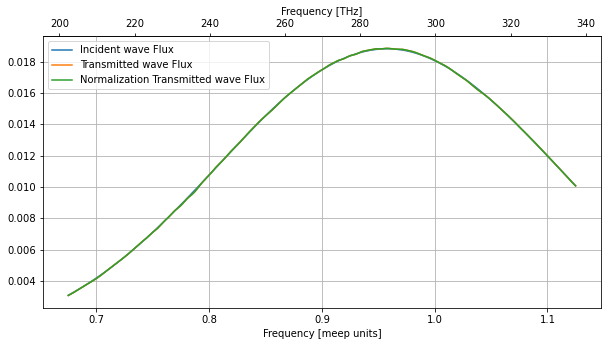

In [12]:
plt.plot(freqs, inc_flux, label="Incident wave Flux")
plt.plot(freqs, tran_flux, label="Transmitted wave Flux")
plt.plot(freqs, tran_flux, label="Normalization Transmitted wave Flux")

plt.xlabel("Frequency [meep units]")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')


plt.legend()
plt.grid()

In [13]:
Tr = np.array(tran_flux)/np.array(tran_flux)

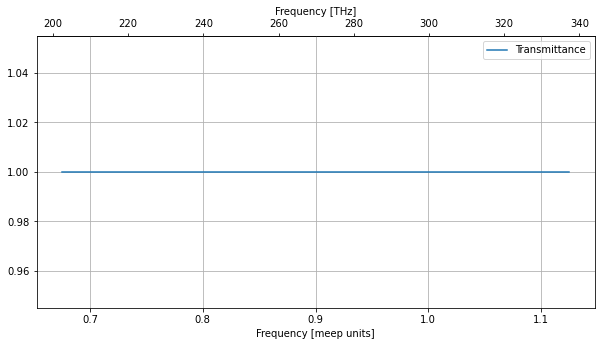

In [14]:
plt.plot(freqs, Tr, label="Transmittance")

plt.xlabel("Frequency [meep units]")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')

plt.legend()
plt.grid()

In [15]:
sim.reset_meep()

# $\Delta \phi$ calculation

In [16]:
run_time = 500

single_freq = 0.9

FloatProgress(value=0.0, description='0% done ', max=500.0)

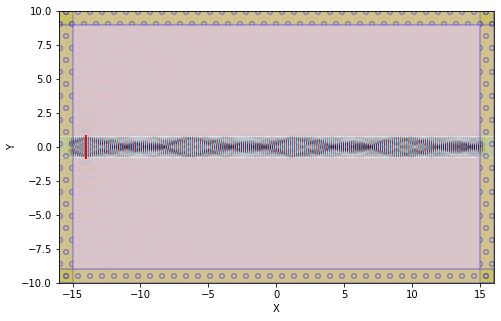

In [17]:
#Geometry objects
waveguide = mp.Block(mp.Vector3(mp.inf, wvg_width, mp.inf),
                    center = mp.Vector3(wvg_x, wvg_y),
                    material = mp.Medium(index=n_wvg))

geometry = [waveguide]

#define sources
#gaussian pulse with f_central and df
sources = [mp.Source(mp.ContinuousSource(frequency=single_freq, width=50),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, source_width))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]

#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    geometry=geometry,
                    resolution=resolution)

animate = mp.Animate2D(sim,
                       fields=mp.Ez,
                       normalize=True,
                       realtime=False,
                       eps_parameters={'alpha':1, 'cmap':'RdBu', 'interpolation':'spline36'},
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})

#Simulate
mp.verbosity(0)
sim.run(mp.at_every(1,animate), until=run_time)

animate.to_mp4(10, "Ez_norm.mp4")

In [18]:
Video("Ez_norm.mp4")

In [19]:
ez_data_wvg = sim.get_array(center=mp.Vector3(0,wvg_y), size=mp.Vector3(sx, 0.001), component=mp.Ez)
print(ez_data_wvg.shape)

x = np.arange(-sx/2, sx/2, 1/resolution)

(640, 2)


No handles with labels found to put in legend.


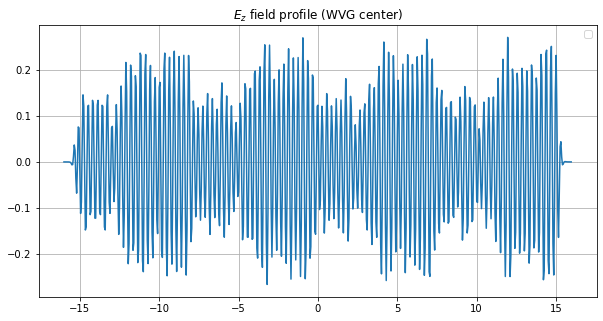

In [20]:
plt.figure()

plt.plot(x, ez_data_wvg[:,0])

plt.title(r"$E_z$ field profile (WVG center)")
plt.legend()
plt.grid()

## $\Delta \phi$ extraction

In [21]:
init_mask = (x>(source_x + 0.4))&(x<((-1)*(ring_r+ring_w)))

init_wave = ez_data_wvg[init_mask][:,0]
init_x = x[init_mask]

fin_mask = (x>(ring_r+ring_w))&(x<(x_bound_up-0.4))

fin_wave = ez_data_wvg[fin_mask][:,0]
fin_x = x[fin_mask]

wv_lngth = 1/(f_central_resonance*n_wvg)
wv_vector = 2*pi/(wv_lngth)


NameError: name 'ring_r' is not defined

In [ ]:
init_peaks, _ = find_peaks(init_wave, height=0.1)
fin_peaks, _ = find_peaks(fin_wave, height=0.0)

init_x_peaks = init_x[init_peaks]
fin_x_peaks = fin_x[fin_peaks]

init_spacings = np.diff(init_x[init_peaks])
fin_spacings = np.diff(fin_x[fin_peaks])

print(init_spacings)
print(fin_spacings)

[3.4 3.5]
[3.45 3.5 ]


## Linear fit to extract wavelength

In [ ]:
def func_linear(m, k, phi):
    return (m*2*pi + pi/2 -phi)/k

popt_init, pcov_init = curve_fit(func_linear, [i[0] for i in enumerate(init_x_peaks)], init_x_peaks)

k_fit_init = popt_init[0]
phi_init = popt_init[1]%(2*pi)

print("K_init: ",k_fit_init," phi_init:", phi_init)
print("wavelength_init: ",2*pi/k_fit_init)


popt_fin, pcov_fin = curve_fit(func_linear, [i[0] for i in enumerate(fin_x_peaks)], fin_x_peaks)

k_fit_fin = popt_fin[0]
phi_fin = popt_fin[1]%(2*pi)

print("K_fin: ",k_fit_fin," phi_fin:", phi_fin)
print("wavelength_fin: ",2*pi/k_fit_fin)


DeltaPhi = phi_fin - phi_init
print("Delta Phi:", DeltaPhi, "Pis:",DeltaPhi/pi, ", Degrees: ",DeltaPhi*360/(2*pi))


K_init:  1.821213132697075  phi_init: 0.4173613447151965
wavelength_init:  3.449999999656645
K_fin:  1.8081108798382568  phi_fin: 0.5009973887814976
wavelength_fin:  3.4749999998571126
Delta Phi: 0.0836360440663011 Pis: 0.026622179667606802 , Degrees:  4.791992340169225


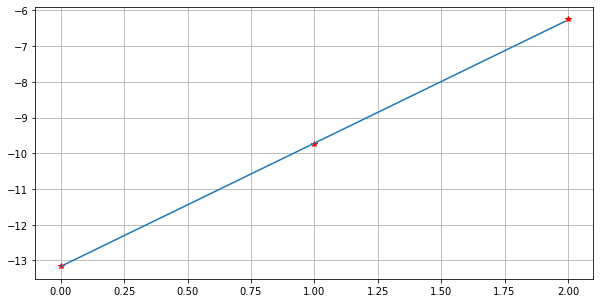

In [ ]:
dummy_m_init = np.arange(np.amin([i[0] for i in enumerate(init_x_peaks)]), np.amax([i[0] for i in enumerate(init_x_peaks)]), 0.01)

plt.plot([i[0] for i in enumerate(init_x_peaks)],init_x_peaks ,"r*")
plt.plot(dummy_m_init, func_linear(dummy_m_init, *popt_init), label=r"linear fit")

plt.grid()

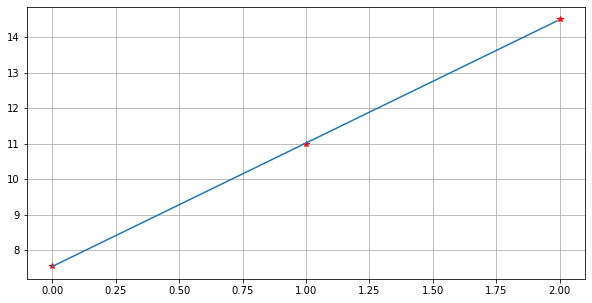

In [ ]:
dummy_m_fin = np.arange(np.amin([i[0] for i in enumerate(fin_x_peaks)]), np.amax([i[0] for i in enumerate(fin_x_peaks)]), 0.01)

plt.plot([i[0] for i in enumerate(fin_x_peaks)],fin_x_peaks,"r*" )
plt.plot(dummy_m_fin, func_linear(dummy_m_fin, *popt_fin), label=r"linear fit")

plt.grid()

In [ ]:
def func_1(x, k, phi):
    return np.amax(init_wave)*np.sin(k*x + phi)

def func_2(x, k, phi):
    return np.amax(fin_wave)*np.sin(k*x + phi)

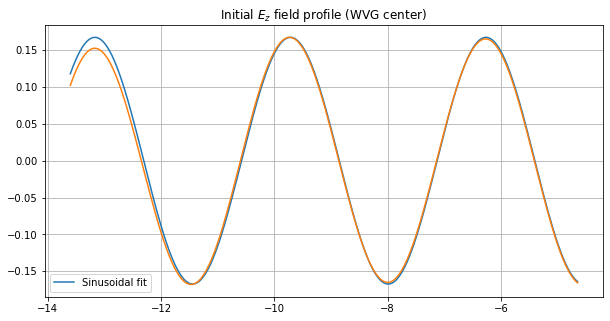

In [ ]:
plt.figure()

dummy_x_init = np.arange(np.amin(init_x), np.amax(init_x), 0.01)

plt.plot(dummy_x_init, func_1(dummy_x_init, *popt_init), label=r"Sinusoidal fit")
plt.plot(init_x, init_wave)

plt.title(r"Initial $E_z$ field profile (WVG center)")
plt.legend()
plt.grid()

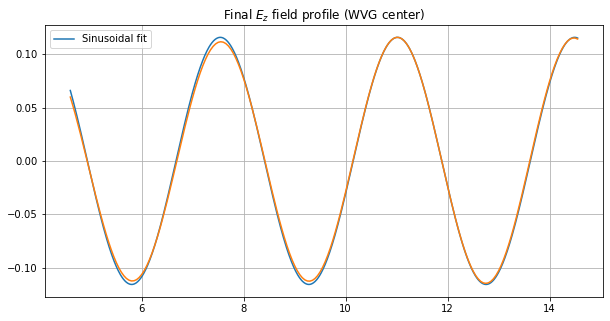

In [ ]:
plt.figure()

dummy_x_fin = np.arange(np.amin(fin_x), np.amax(fin_x), 0.01)

plt.plot(dummy_x_fin, func_2(dummy_x_fin, *popt_fin), label=r"Sinusoidal fit")
plt.plot(fin_x, fin_wave)

plt.title(r"Final $E_z$ field profile (WVG center)")
plt.legend()
plt.grid()

In [ ]:
## Sinusoidal fit, not very accurate
def func_1(x, k, phi):
    return np.amax(init_wave)*np.sin(k*x + phi)

def func_2(x, k, phi):
    return np.amax(fin_wave)*np.sin(k*x + phi)

popt_init_sine, pcov_init_sine = curve_fit(func_1, init_x, init_wave, p0=[wv_vector,0])
popt_fin_sine, pcov_fin_sine = curve_fit(func_2, fin_x, fin_wave,p0=[wv_vector,0])

print(popt_init_sine)
print(popt_fin_sine)

[2.83376989 6.68642632]
[1.8110122  0.47247476]


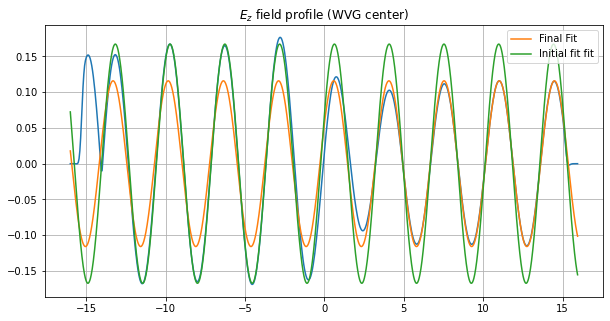

In [ ]:
plt.figure()

dummy_x = np.arange(np.amin(x), np.amax(x), 0.01)

plt.plot(x, ez_data_wvg[:,0])
plt.plot(dummy_x, func_2(dummy_x, *popt_fin), label=r"Final Fit")
plt.plot(dummy_x, func_1(dummy_x, *popt_init), label=r"Initial fit fit")


plt.title(r"$E_z$ field profile (WVG center)")
plt.legend()
plt.grid()

# Notes